# Deep Neural Network Evaluation Report

This notebook evaluates deep neural network models based on their performance metrics.
It visualizes key patterns and provides guidance on model comparison and selection.

# Imports and Preprocessing

In [32]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LogNorm
from os.path import join
import ast
from matplotlib import colormaps
from matplotlib.colors import Normalize


# Load your dataset
df = pd.read_csv(join("data", "DNN_trained_models_docs.csv"))

# Filter to only include models from a certain data_file
data_file = "results_3D_GE_Applied_Current_1MKOH_63_03_1MKOH_input_parameters_DOE_maximin_lhs_success_001.csv"
df = df[df["data_file"] == data_file]

# Add readable column names
df = df.reset_index(drop=True)
df["model_id"] = df.index.map(lambda i: f"Model_{i:03d}")



# 1. Hyperparameter Evaluation

## 1.1 Hidden Layers

This section evaluates how the structure of hidden layers affects model performance.

**Goals:**
- Assess how the number of layers and neurons impacts MAE and RMSE.
- Determine whether larger architectures consistently lead to better models.

**Key Features Evaluated:**
- `num_layers`: total number of hidden layers
- `layer_sizes`: list of neurons per layer
- `total_units`: total number of neurons (sum over all layers)


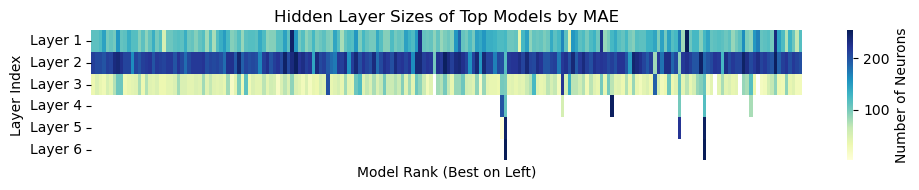

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# --- Top models based on MAE ---
top_models = df.nsmallest(200, "mae")[["model_id", "layer_sizes"]].copy()
top_models["layer_sizes"] = top_models["layer_sizes"].apply(ast.literal_eval)

# Pad with NaN for models with fewer layers
max_layers = max(len(l) for l in top_models["layer_sizes"])
layer_matrix = [l + [np.nan] * (max_layers - len(l)) for l in top_models["layer_sizes"]]
layer_df = pd.DataFrame(layer_matrix, index=top_models["model_id"])
layer_df.columns = [f"Layer {i+1}" for i in range(max_layers)]

# Replace zeros with NaN (if any)
layer_df_safe = layer_df.replace(0, np.nan)

# Transpose and reverse columns so best model is on the left
layer_df_safe_T = layer_df_safe.T # Transpose + flip columns

# Plot heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(
    layer_df_safe_T,
    annot=False,
    cmap="YlGnBu",
    cbar_kws={'label': 'Number of Neurons'},
    vmin=layer_df_safe.min().min(),
    vmax=layer_df_safe.max().max()
)
plt.title("Hidden Layer Sizes of Top Models by MAE")
plt.ylabel("Layer Index")
plt.xlabel("Model Rank (Best on Left)")
plt.xticks([], [])
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


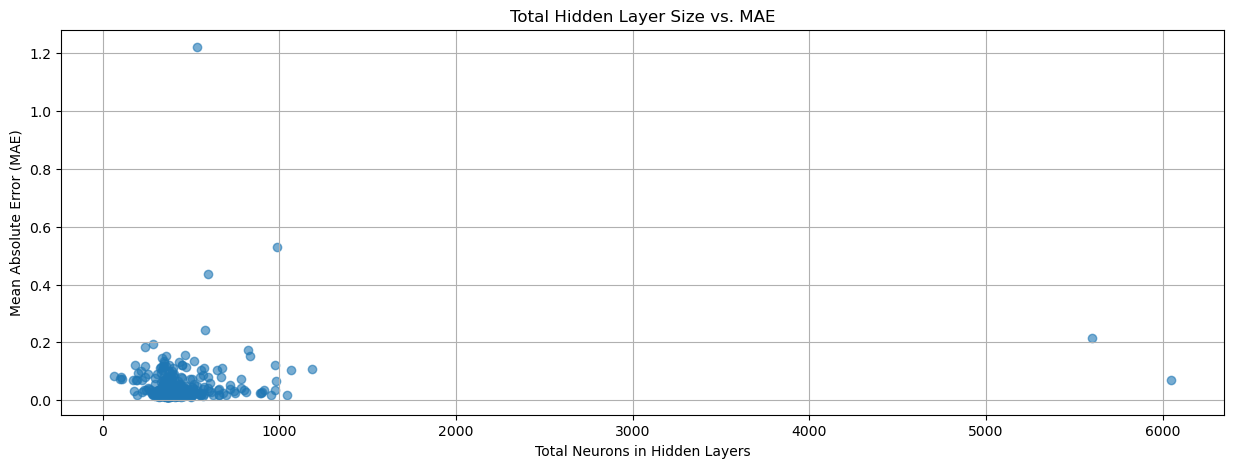

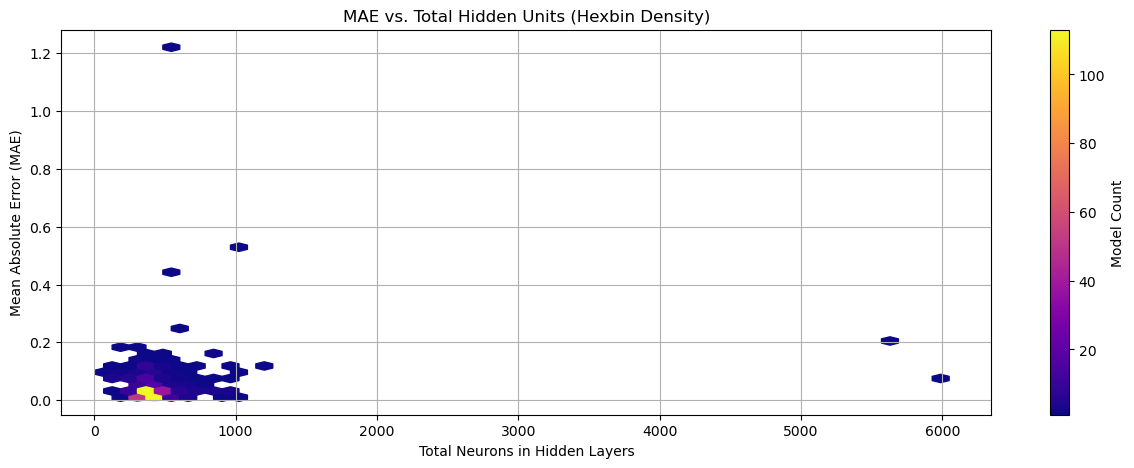

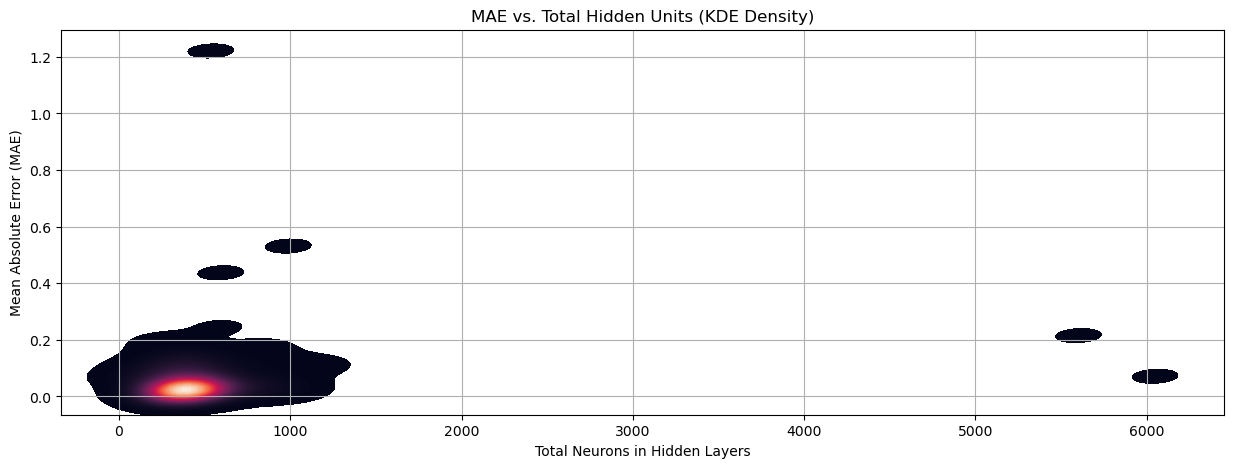

C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\2455629936.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df.groupby("bin")["mae"].median().reset_index()


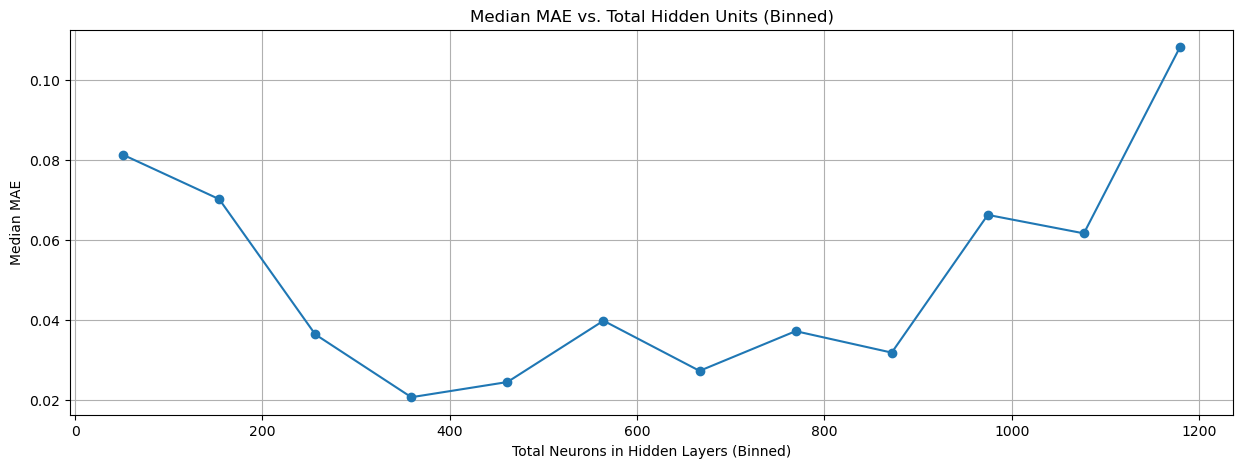

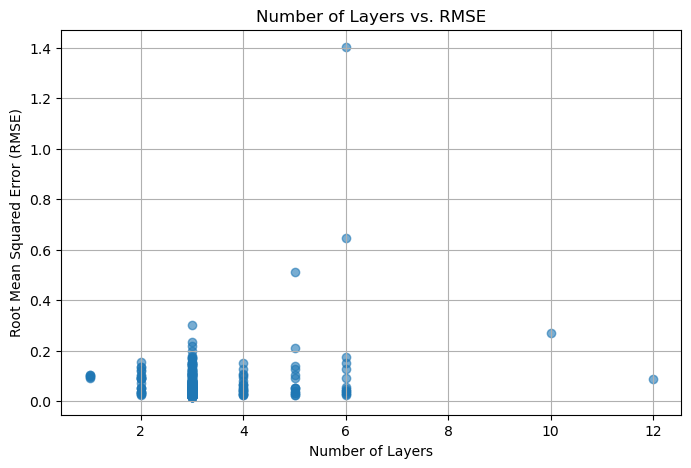

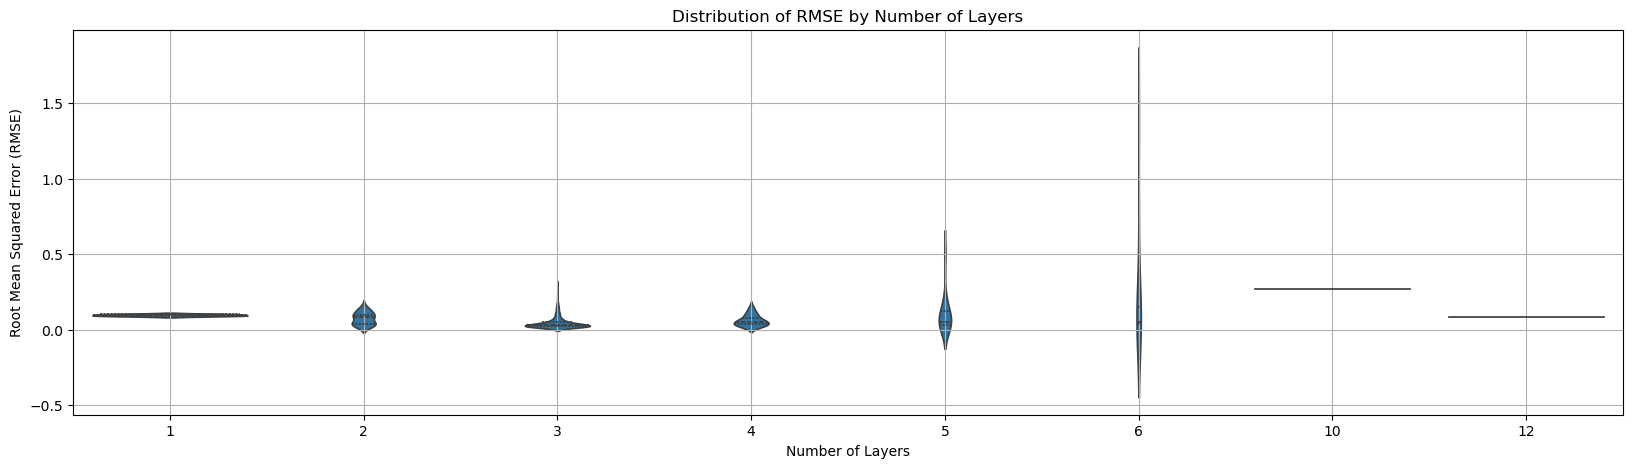

In [34]:
# Parse layer sizes into a list and compute total units
df["layer_sizes_list"] = df["layer_sizes"].apply(ast.literal_eval)
df["total_units"] = df["layer_sizes_list"].apply(sum)



# Plot: Total units vs MAE
plt.figure(figsize=(15, 5))
plt.scatter(df["total_units"], df["mae"], alpha=0.6)
# plt.ylim(0, 0.3)
# plt.xlim(0, 4000)
plt.xlabel("Total Neurons in Hidden Layers")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Total Hidden Layer Size vs. MAE")
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 5))
hb = plt.hexbin(df["total_units"], df["mae"], gridsize=50, cmap="plasma", mincnt=1)
plt.colorbar(hb, label="Model Count")
plt.xlabel("Total Neurons in Hidden Layers")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Total Hidden Units (Hexbin Density)")
# plt.ylim(0, 0.3)
# plt.xlim(0, 4000)
plt.grid(True)
plt.show()

import seaborn as sns

plt.figure(figsize=(15, 5))
sns.kdeplot(
    x=df["total_units"],
    y=df["mae"],
    fill=True,
    cmap="rocket",
    thresh=0.01,
    levels=100
)
plt.xlabel("Total Neurons in Hidden Layers")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Total Hidden Units (KDE Density)")
# plt.ylim(0, 0.3)
# plt.xlim(0, 4000)
plt.grid(True)
plt.show()



df["bin"] = pd.cut(df["total_units"], bins=np.linspace(0, 4000, 40))
bin_summary = df.groupby("bin")["mae"].median().reset_index()
bin_summary["bin_center"] = bin_summary["bin"].apply(lambda b: b.mid)

plt.figure(figsize=(15, 5))
plt.plot(bin_summary["bin_center"], bin_summary["mae"], marker="o")
plt.xlabel("Total Neurons in Hidden Layers (Binned)")
plt.ylabel("Median MAE")
plt.title("Median MAE vs. Total Hidden Units (Binned)")
plt.grid(True)
plt.show()




# Plot: num_layers vs RMSE
plt.figure(figsize=(8, 5))
plt.scatter(df["num_layers"], df["rmse"], alpha=0.6)
plt.xlabel("Number of Layers")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Number of Layers vs. RMSE")
plt.grid(True)
plt.show()

# Violin Plot: Number of layers vs rmse
plt.figure(figsize=(20, 5))
sns.violinplot(x="num_layers", y="rmse", data=df, inner="quartile")
plt.xlabel("Number of Layers")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Distribution of RMSE by Number of Layers")
plt.grid(True)
plt.show()


## 1.2 Learning Rate

The learning rate controls how quickly the model updates weights during training.

**Too small**: slow convergence  
**Too large**: unstable or divergent training

This plot helps assess how learning rate affects final model performance.


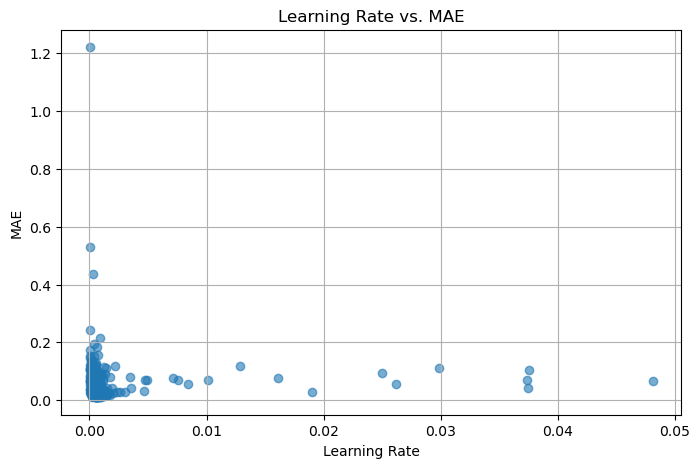

In [35]:
# Plot: learning rate vs MAE
plt.figure(figsize=(8, 5))
plt.scatter(df["learning_rate"], df["mae"], alpha=0.6)
plt.xlabel("Learning Rate")
plt.ylabel("MAE")
plt.title("Learning Rate vs. MAE")
plt.grid(True)
plt.show()


## 1.3 Epochs

Epochs define how many times the model sees the full training data.

**Fewer epochs**: risk of underfitting  
**Too many**: risk of overfitting

We compare number of epochs to performance metrics and check best_epoch from early stopping.


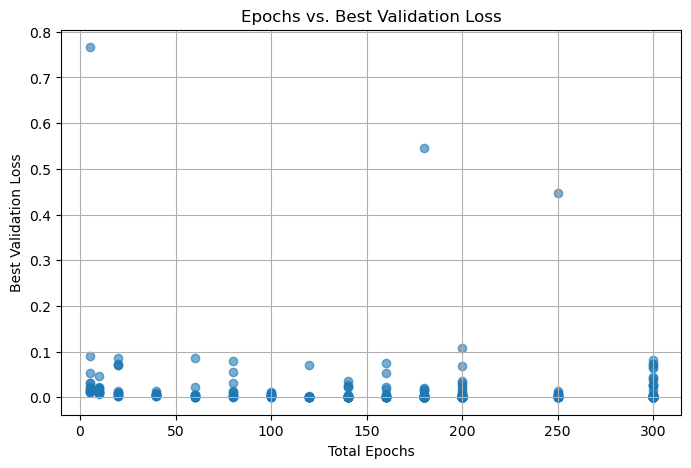

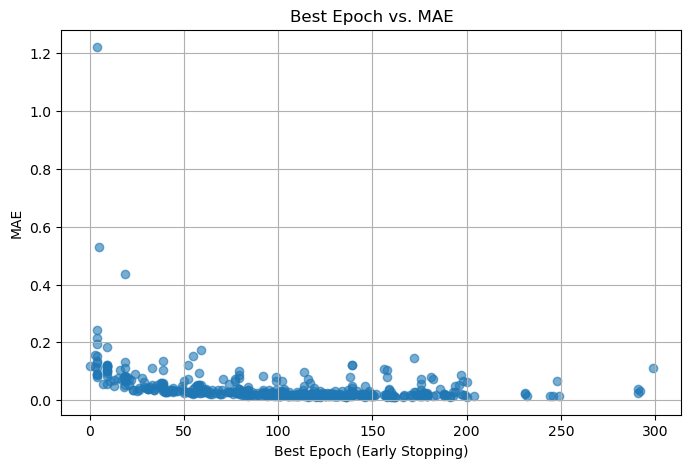

In [36]:
# Plot: epochs vs val_loss_best
plt.figure(figsize=(8, 5))
plt.scatter(df["epochs"], df["val_loss_best"], alpha=0.6)
plt.xlabel("Total Epochs")
plt.ylabel("Best Validation Loss")
plt.title("Epochs vs. Best Validation Loss")
plt.grid(True)
plt.show()

# Plot: best_epoch vs MAE
plt.figure(figsize=(8, 5))
plt.scatter(df["best_epoch"], df["mae"], alpha=0.6)
plt.xlabel("Best Epoch (Early Stopping)")
plt.ylabel("MAE")
plt.title("Best Epoch vs. MAE")
plt.grid(True)
plt.show()


## 1.4 Batch Size

Batch size controls how many samples are used in each training update.

**Smaller** batches improve generalization but slow training.  
**Larger** batches can speed up training but risk poor minima.

We explore how batch size affects MAE and inference time.


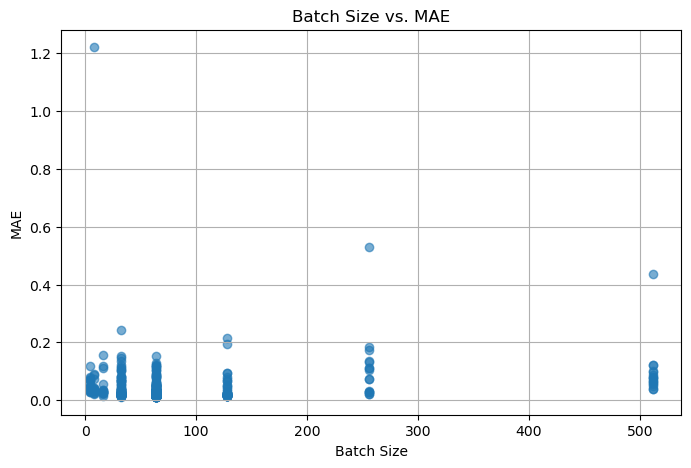

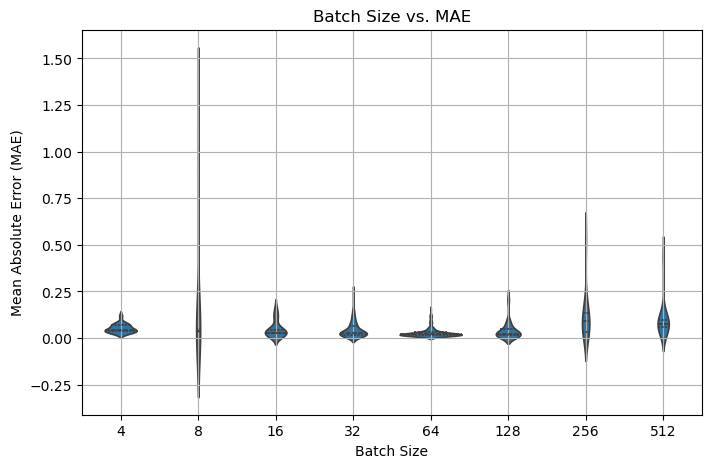

In [37]:
# Plot: batch size vs MAE
plt.figure(figsize=(8, 5))
plt.scatter(df["batch_size"], df["mae"], alpha=0.6)
plt.xlabel("Batch Size")
plt.ylabel("MAE")
plt.title("Batch Size vs. MAE")
plt.grid(True)
plt.show()

# Violing plot: batch size vs MAE
plt.figure(figsize=(8, 5))
sns.violinplot(x="batch_size", y="mae", data=df, inner="quartile")
plt.xlabel("Batch Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Batch Size vs. MAE")
plt.grid(True)
plt.show()


## 1.5 Activation Function

Activation functions introduce nonlinearity into the network.

Common options:
- `relu`: fast and effective; default in most cases
- `tanh`: squashes output between -1 and 1; can help with symmetry
- `sigmoid`: rarely used in hidden layers due to vanishing gradients

We compare the distribution of MAE across activation functions.


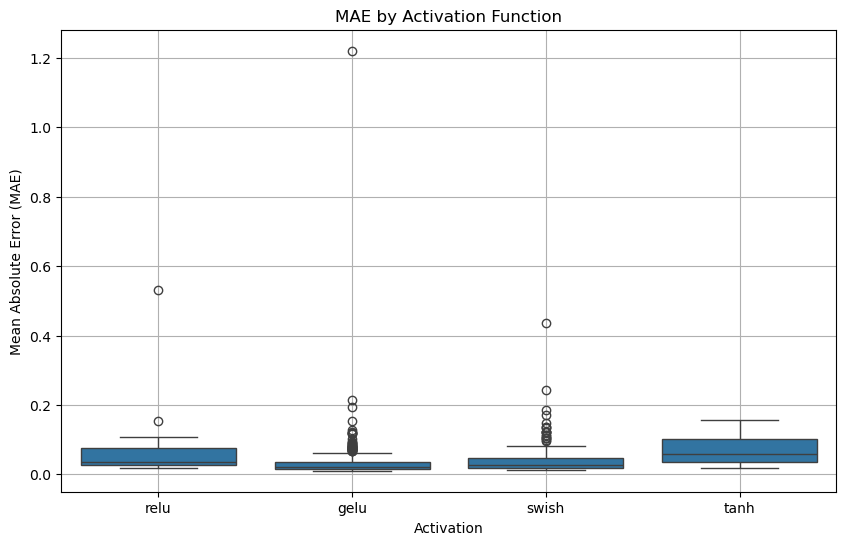

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="activation", y="mae")
plt.title("MAE by Activation Function")
plt.xlabel("Activation")
plt.ylabel("Mean Absolute Error (MAE)")
plt.grid(True)
plt.show()


## 1.6 Loss Function

The loss function guides the training process.

For regression, common choices are:
- `mse` (Mean Squared Error): penalizes larger errors more
- `mae` (Mean Absolute Error): less sensitive to outliers

We compare how choice of loss affects model performance.


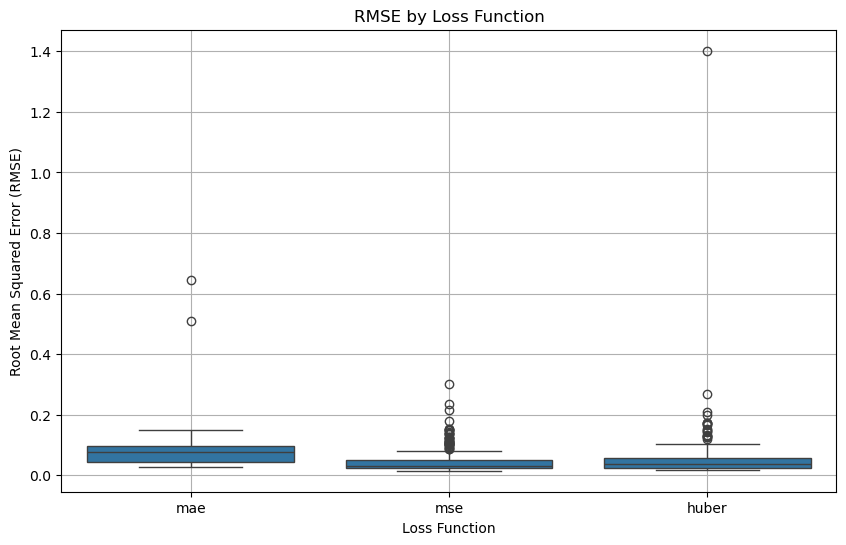

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="loss_function", y="rmse")
plt.title("RMSE by Loss Function")
plt.xlabel("Loss Function")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.grid(True)
plt.show()


## 1.7 Optimizer

Optimizers update model weights based on gradients. Popular options:
- `Adam`: adaptive learning rate, widely used
- `SGD`: classic stochastic gradient descent
- `RMSprop`: good for recurrent networks

We evaluate how optimizer choice affects composite model quality.


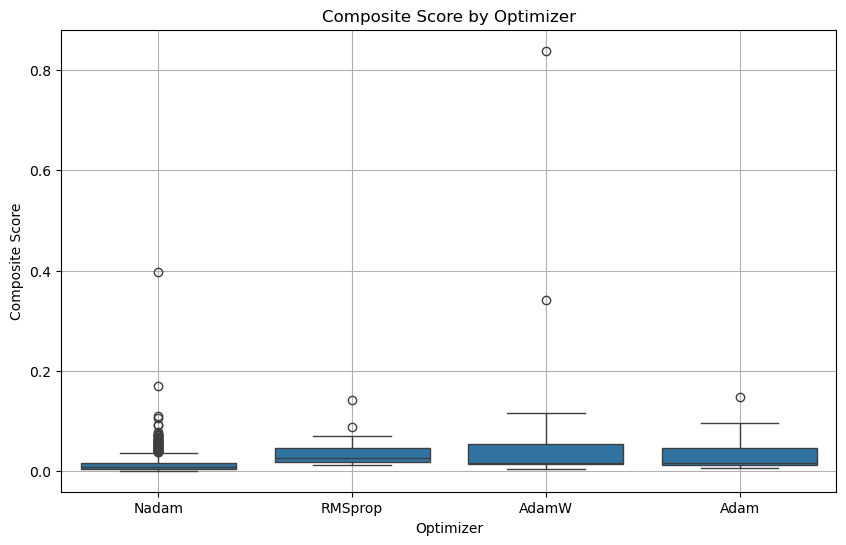

In [40]:
metrics = ["mae", "rmse", "val_loss_best", "mape", "median_ae", "inference_time_ms"]
scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[[f"{m}_norm" for m in metrics]] = scaler.fit_transform(df[metrics])
df["composite_score"] = df_norm[[f"{m}_norm" for m in metrics]].mean(axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="optimizer", y="composite_score")
plt.title("Composite Score by Optimizer")
plt.xlabel("Optimizer")
plt.ylabel("Composite Score")
plt.grid(True)
plt.show()


## 1.8 Dropout Rate

Dropout randomly disables neurons during training to prevent co-adaptation.

**Goal:** Improve generalization and reduce overfitting.

Typical range: 0.2 to 0.5.  
We examine how dropout rate affects performance and validation loss.


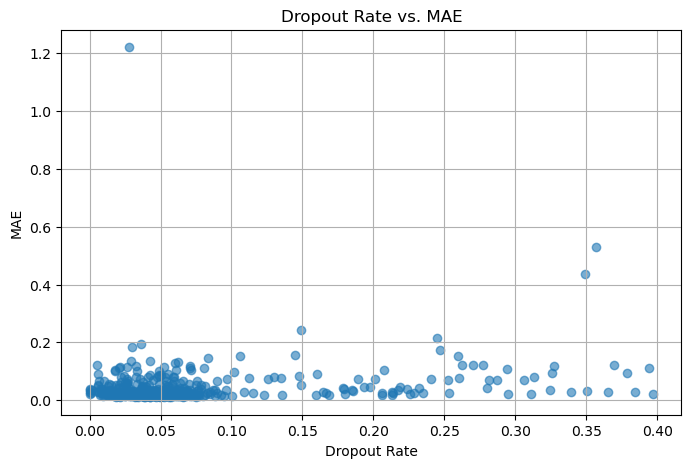

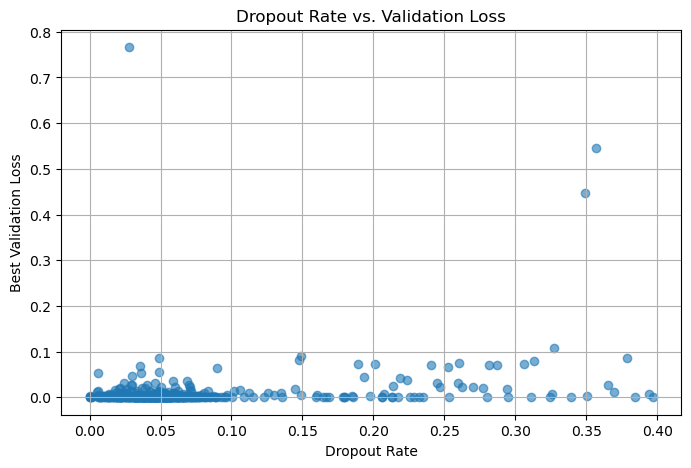

In [41]:
# Plot: dropout vs MAE
plt.figure(figsize=(8, 5))
plt.scatter(df["dropout_rate"], df["mae"], alpha=0.6)
plt.xlabel("Dropout Rate")
plt.ylabel("MAE")
plt.title("Dropout Rate vs. MAE")
plt.grid(True)
plt.show()

# Plot: dropout vs val_loss_best
plt.figure(figsize=(8, 5))
plt.scatter(df["dropout_rate"], df["val_loss_best"], alpha=0.6)
plt.xlabel("Dropout Rate")
plt.ylabel("Best Validation Loss")
plt.title("Dropout Rate vs. Validation Loss")
plt.grid(True)
plt.show()


# 2. Evaluating All Models Against the Evaluation Metrics




This section visualizes model performance across evaluation metrics to help identify:

- Underperforming models
- Overfitting tendencies
- General trends and trade-offs between metrics

We focus on pairwise metric comparisons and their distribution across the model population.

## 2.1 Validation Loss vs. MAE

This plot highlights how validation loss correlates with Mean Absolute Error (MAE).

**Interpretation:**
- Bottom-left corner: strong models (low validation loss and low MAE)
- Top-right corner: weak or overfitted models
- Discrepancy between validation loss and MAE could indicate poor generalization


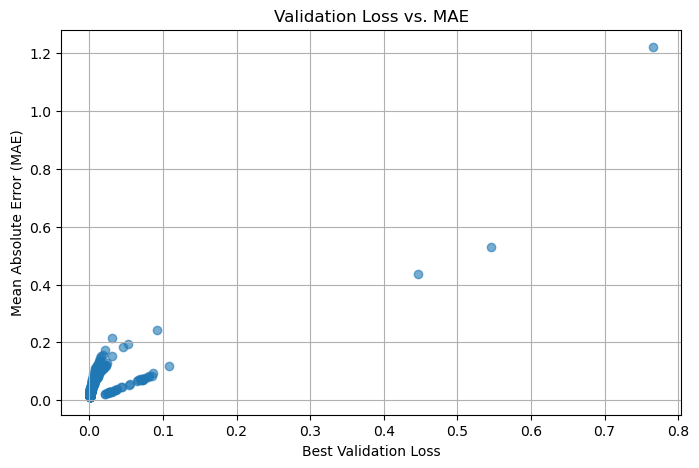

In [42]:
plt.figure(figsize=(8, 5))
plt.scatter(df["val_loss_best"], df["mae"], alpha=0.6)
plt.xlabel("Best Validation Loss")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Validation Loss vs. MAE")
plt.grid(True)
plt.show()


## 2.2 MAE vs. RMSE

This plot compares two error metrics: MAE and RMSE.

**Interpretation:**
- RMSE penalizes large errors more heavily than MAE.
- A strong correlation is expected, but large outliers in RMSE can signal unstable predictions.


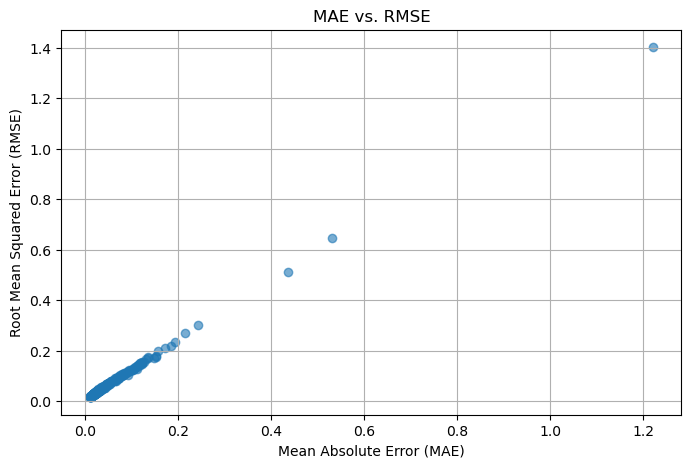

In [43]:
plt.figure(figsize=(8, 5))
plt.scatter(df["mae"], df["rmse"], alpha=0.6)
plt.xlabel("Mean Absolute Error (MAE)")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("MAE vs. RMSE")
plt.grid(True)
plt.show()


## 2.3 R² vs. MAE

The R² score measures how well predictions capture variance in the data.

**Interpretation:**
- Models with higher R² and lower MAE are ideal.
- Low R² despite low MAE may occur if the model fits only a narrow range of the output space.


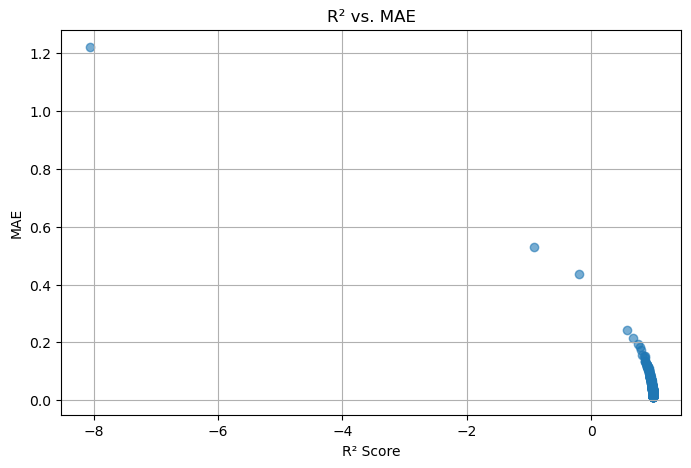

In [44]:
plt.figure(figsize=(8, 5))
plt.scatter(df["r2"], df["mae"], alpha=0.6)
plt.xlabel("R² Score")
plt.ylabel("MAE")
plt.title("R² vs. MAE")
plt.grid(True)
plt.show()


## 2.4 Inference Time vs. MAE

This explores the trade-off between model complexity (measured indirectly via inference time) and prediction accuracy.

**Interpretation:**
- Ideally, a model should be both fast and accurate.
- Top-left corner: best-performing models in production settings.


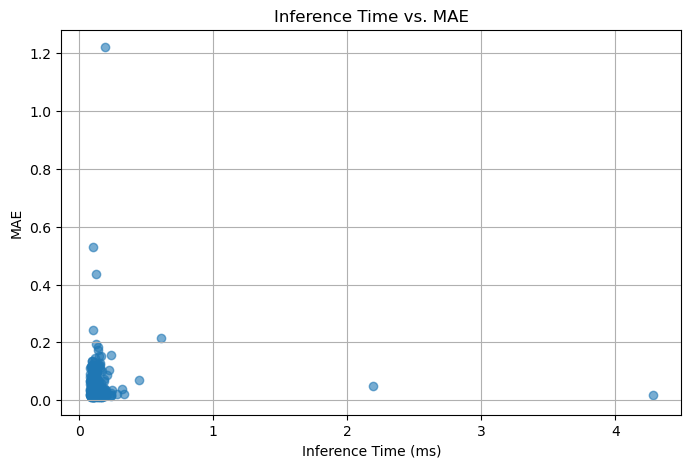

In [45]:
plt.figure(figsize=(8, 5))
plt.scatter(df["inference_time_ms"], df["mae"], alpha=0.6)
plt.xlabel("Inference Time (ms)")
plt.ylabel("MAE")
plt.title("Inference Time vs. MAE")
plt.grid(True)
plt.show()


## 2.5 All parameters

C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\1258403346.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_mae.index, y=top_mae["mae"], palette="viridis")


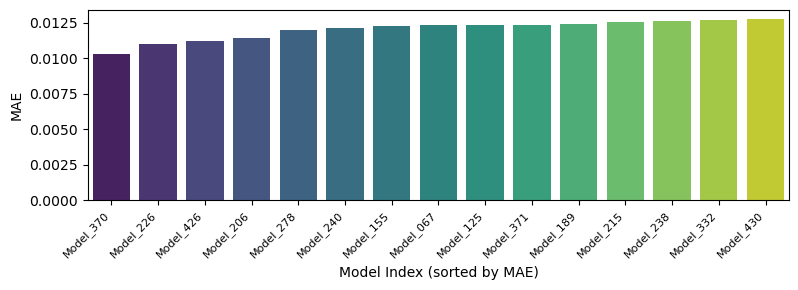

In [46]:
# Plot top models sorted by MAE
top_mae = df.sort_values("mae").head(15).reset_index(drop=True)

plt.figure(figsize=(8, 3))
sns.barplot(x=top_mae.index, y=top_mae["mae"], palette="viridis")
plt.xticks(ticks=range(15), labels=top_mae["model_id"], rotation=45, ha="right", fontsize=8)
# plt.title("Top 15 Models – MAE")
plt.xlabel("Model Index (sorted by MAE)")
plt.ylabel("MAE")
plt.tight_layout()
# plt.savefig("IMAGES/mae_top_models.png")
plt.show()


C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\1266638185.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_r2.index, y=top_r2["r2"], palette="viridis")


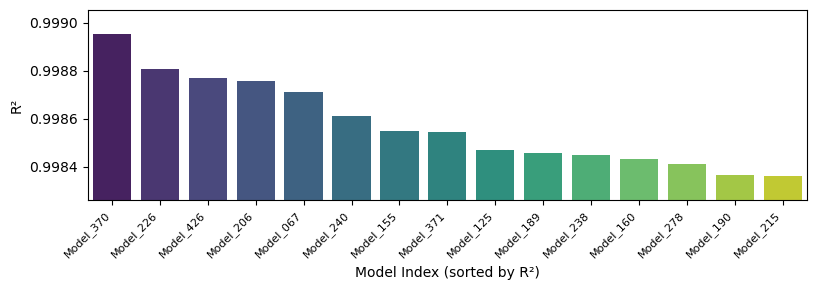

In [47]:
top_r2 = df.sort_values("r2", ascending=False).head(15).reset_index(drop=True)

plt.figure(figsize=(8, 3))
sns.barplot(x=top_r2.index, y=top_r2["r2"], palette="viridis")
plt.xticks(ticks=range(15), labels=top_r2["model_id"], rotation=45, ha="right", fontsize=8)
# plt.title("Top 15 Models – R²")
plt.xlabel("Model Index (sorted by R²)")
plt.ylabel("R²")
plt.tight_layout()
plt.ylim(top_r2["r2"].min() - 0.0001, top_r2["r2"].max() + 0.0001)
# plt.savefig("IMAGES/r2_top_models.png")
plt.show()


C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\1901354589.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_rmse.index, y=top_rmse["rmse"], palette="viridis")


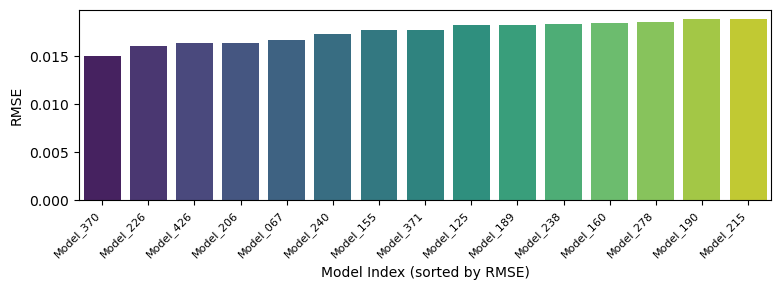

In [48]:
top_rmse = df.sort_values("rmse").head(15).reset_index(drop=True)

plt.figure(figsize=(8, 3))
sns.barplot(x=top_rmse.index, y=top_rmse["rmse"], palette="viridis")
plt.xticks(ticks=range(15), labels=top_rmse["model_id"], rotation=45, ha="right", fontsize=8)
# plt.title("Top 15 Models – RMSE")
plt.xlabel("Model Index (sorted by RMSE)")
plt.ylabel("RMSE")
plt.tight_layout()
# plt.savefig("IMAGES/rmse_top_models.png")
plt.show()


C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\2324091037.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_med_ae.index, y=top_med_ae["median_ae"], palette="viridis")


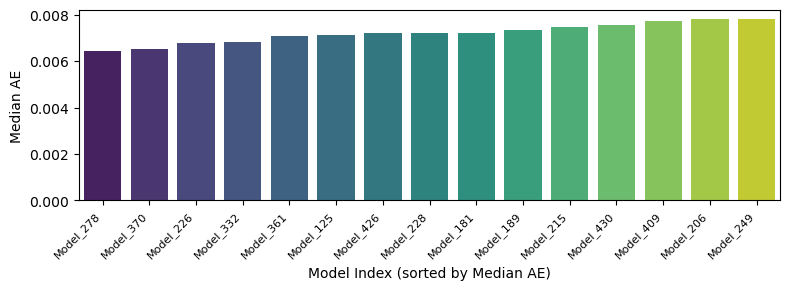

In [49]:
top_med_ae = df.sort_values("median_ae").head(15).reset_index(drop=True)

plt.figure(figsize=(8, 3))
sns.barplot(x=top_med_ae.index, y=top_med_ae["median_ae"], palette="viridis")
plt.xticks(ticks=range(15), labels=top_med_ae["model_id"], rotation=45, ha="right", fontsize=8)
# plt.title("Top 15 Models – Median Absolute Error")
plt.xlabel("Model Index (sorted by Median AE)")
plt.ylabel("Median AE")
plt.tight_layout()
# plt.savefig("IMAGES/median_ae_top_models.png")
plt.show()


C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\880726907.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_df.index, y=values, palette=colors, ax=ax)
C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\880726907.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_df.index, y=values, palette=colors, ax=ax)
C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\880726907.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_df.index, y=values, palette=colors, ax=ax)
C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\88072690


Top 5 Models by MAE:
 model_id      mae       r2     rmse  median_ae
Model_370 0.010299 0.998953 0.015070   0.006534
Model_226 0.010998 0.998808 0.016082   0.006789
Model_426 0.011184 0.998768 0.016350   0.007201
Model_206 0.011403 0.998758 0.016411   0.007812
Model_278 0.011984 0.998410 0.018568   0.006434


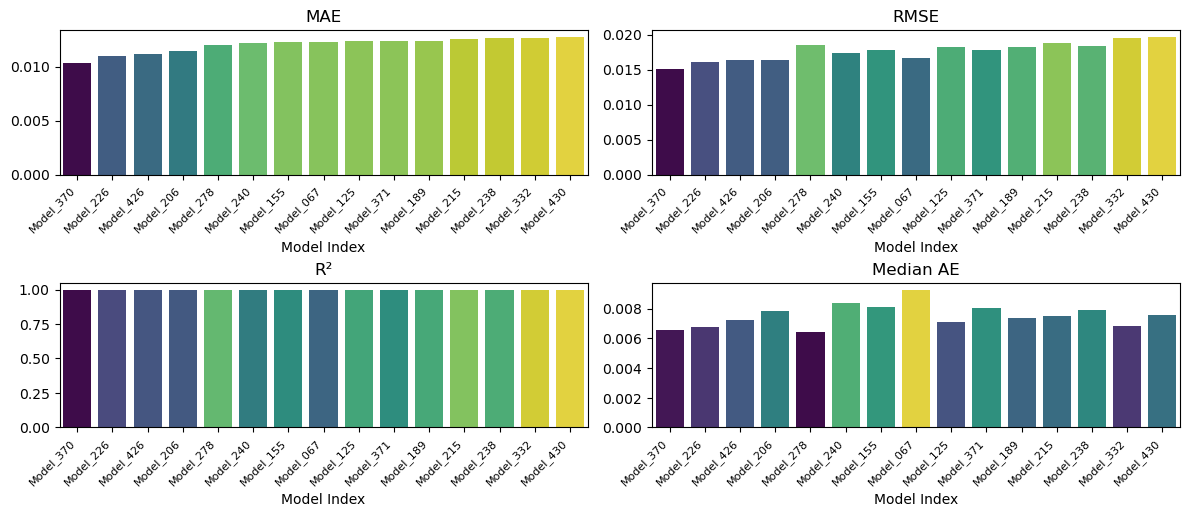

In [50]:
from matplotlib.colors import Normalize
from matplotlib import colormaps
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = df[['model_id', 'mae', 'r2', 'rmse', 'median_ae']].copy()
plot_df = plot_df.sort_values(by='mae').head(15).reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
metrics = ['mae', 'rmse', 'r2', 'median_ae']
titles = ['MAE', 'RMSE', 'R²', 'Median AE']
cmap = colormaps["viridis"]

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    values = plot_df[metric].values

    # Rank performance: best = 0, worst = 1
    if metric == "r2":
        ranks = values.max() - values  # Higher is better → flip
    else:
        ranks = values - values.min()  # Lower is better

    norm = Normalize(vmin=ranks.min(), vmax=ranks.max())
    colors = [cmap(norm(v)) for v in ranks]

    sns.barplot(x=plot_df.index, y=values, palette=colors, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Model Index')
    ax.set_xticks(plot_df.index)
    ax.set_xticklabels(plot_df['model_id'], rotation=45, ha='right', fontsize=8)
    ax.grid(False)

# Print table with top 5 models
plot_df_top5 = plot_df.head(5)
print("\nTop 5 Models by MAE:")
print(plot_df_top5.to_string(index=False))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(top=0.85)
# plt.suptitle("Top 15 Models – Metric Comparison", fontsize=16)
plt.show()


# 3. Composite Score Evaluation



Instead of relying on a single metric, we compute a composite score that balances multiple evaluation metrics.

**Purpose:** Identify models that perform consistently well across multiple criteria.

**Metrics Used:**
- MAE
- RMSE
- MAPE
- Median Absolute Error
- Validation Loss
- Inference Time

Each metric is normalized to [0, 1] using Min-Max scaling, and the composite score is the average of the normalized values (lower is better).


## 3.1 Normalize and Compute Composite Score

In [51]:
from sklearn.preprocessing import MinMaxScaler

# Define and normalize metrics
metrics = ["mae", "rmse", "median_ae", "r2_inverted"]
df["r2_inverted"] = 1 - df["r2"]

scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[[f"{m}_norm" for m in metrics]] = scaler.fit_transform(df[metrics])

# Composite score: lower is better
df["composite_score"] = df_norm[[f"{m}_norm" for m in metrics]].mean(axis=1)

# Display top 5
top = df.sort_values("composite_score").head(5)
top[["model_name", "composite_score"] + metrics]


,model_name,composite_score,mae,rmse,median_ae,r2_inverted
370,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000021,0.010299,0.015070,0.006534,0.001047
226,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000405,0.010998,0.016082,0.006789,0.001192
426,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000578,0.011184,0.016350,0.007201,0.001232
206,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000761,0.011403,0.016411,0.007812,0.001242
278,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000994,0.011984,0.018568,0.006434,0.001590


C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\3945377038.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\3945377038.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\3945377038.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\ebben\AppData\Local\Temp\ipykernel_39836\3945377038.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

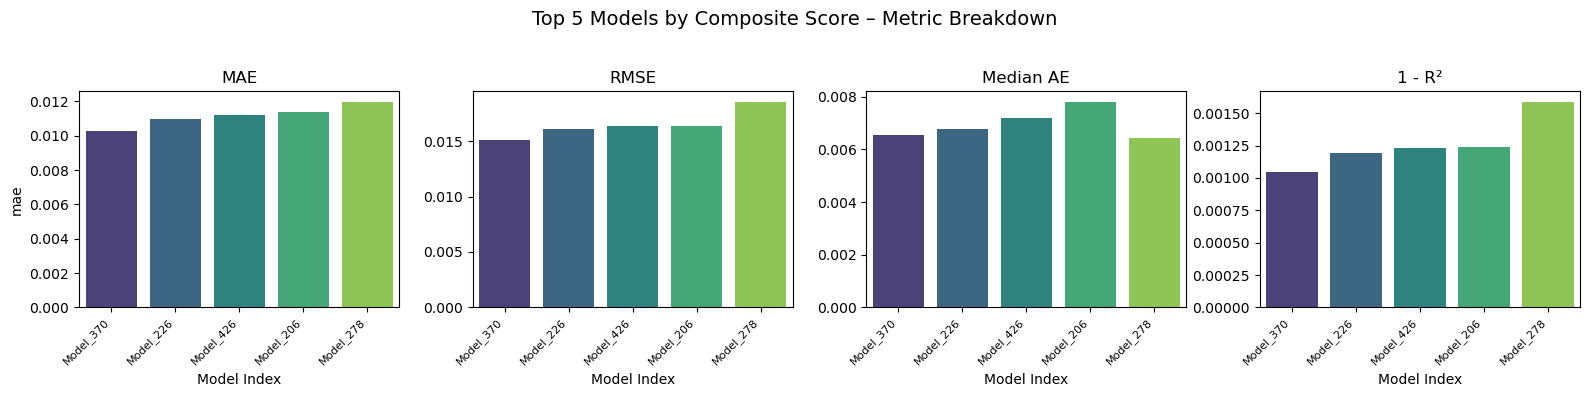

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
top_n = 5
metrics_to_plot = ["mae", "rmse", "median_ae", "r2_inverted"]
titles = ["MAE", "RMSE", "Median AE", "1 - R²"]
top_models = df.sort_values("composite_score").head(top_n).reset_index(drop=True)

# Set up figure
fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(16, 4), sharex=True)

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[i]
    sns.barplot(
        x=top_models.index,
        y=top_models[metric],
        palette="viridis",
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Model Index")
    ax.set_ylabel(metric if i == 0 else "")
    ax.set_xticks(range(top_n))
    ax.set_xticklabels(top_models["model_id"], rotation=45, ha='right', fontsize=8)

plt.suptitle("Top 5 Models by Composite Score – Metric Breakdown", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 3.2 Composite Score Distribution

This histogram shows how the composite scores are distributed.

**Interpretation:**
- Left tail: best-performing models
- Right tail: consistently poor models


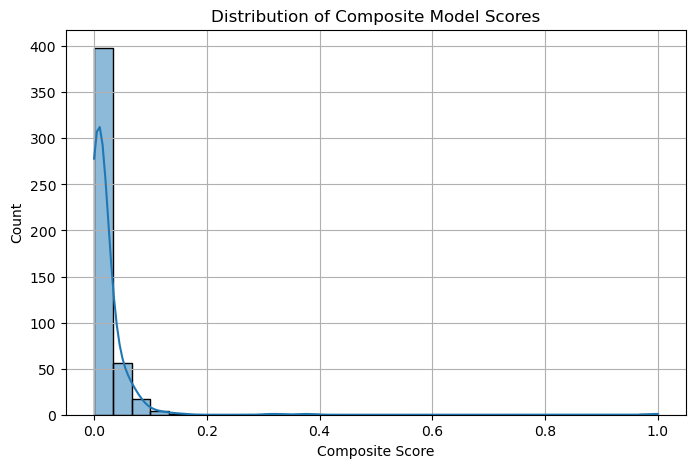

In [53]:
plt.figure(figsize=(8, 5))
sns.histplot(df["composite_score"], bins=30, kde=True)
plt.xlabel("Composite Score")
plt.title("Distribution of Composite Model Scores")
plt.grid(True)
plt.show()


## 3.3 Composite Score vs. Validation Loss

This scatter plot shows how the composite score relates to validation performance.

**Interpretation:**
- A tight correlation here validates the usefulness of the composite score.
- Outliers may indicate models that are fast but inaccurate, or accurate but slow.


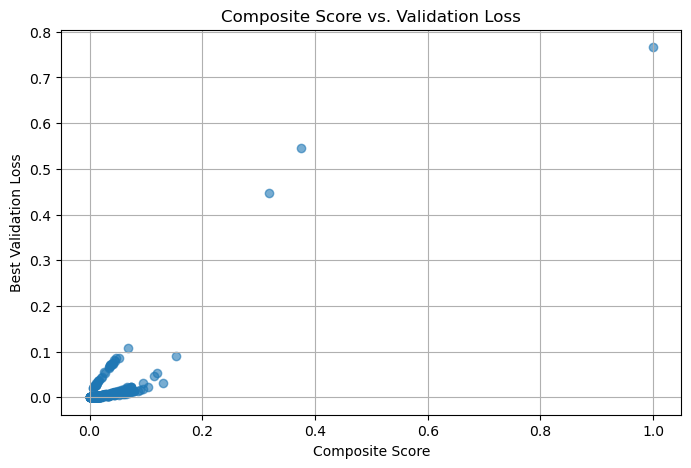

In [54]:
plt.figure(figsize=(8, 5))
plt.scatter(df["composite_score"], df["val_loss_best"], alpha=0.6)
plt.xlabel("Composite Score")
plt.ylabel("Best Validation Loss")
plt.title("Composite Score vs. Validation Loss")
plt.grid(True)
plt.show()


# 4. Correlation Analysis



Understanding correlations between metrics helps to:

- Detect redundancy among metrics (e.g., MAE and RMSE often track closely)
- Identify hidden dependencies
- Guide metric selection for composite scores or hyperparameter tuning

We compute the Pearson correlation matrix and visualize it using a heatmap.


## 4.1 Correlation Matrix and Heatmap

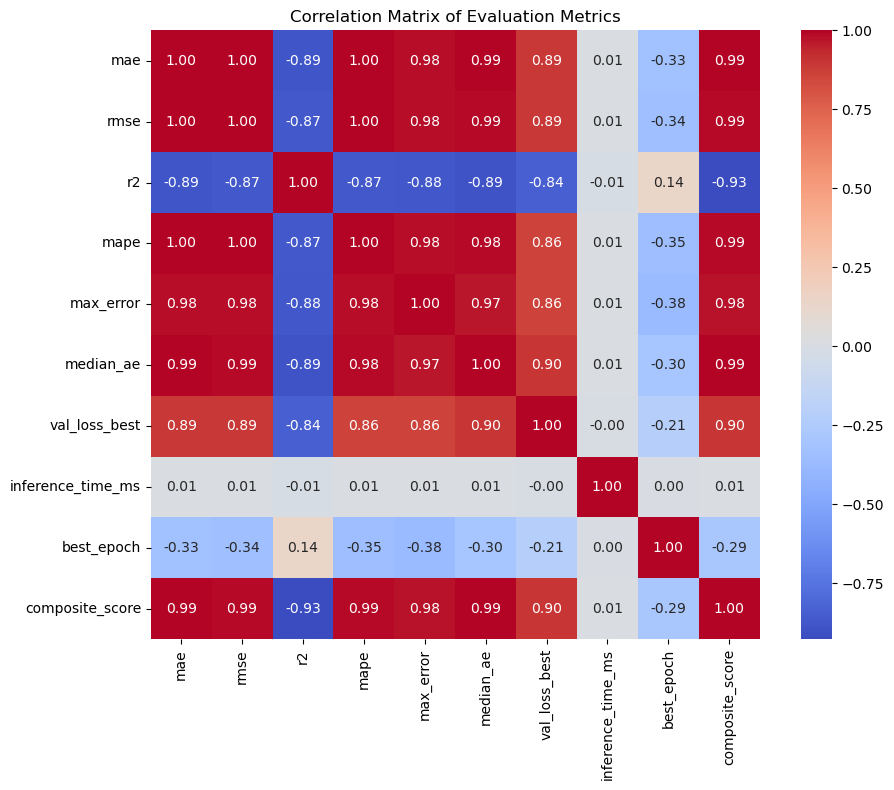

In [55]:
# Select numeric columns of interest
correlation_metrics = [
    "mae", "rmse", "r2", "mape", "max_error", "median_ae",
    "val_loss_best", "inference_time_ms", "best_epoch", "composite_score"
]

# Compute correlation matrix
corr_matrix = df[correlation_metrics].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Evaluation Metrics")
plt.tight_layout()
plt.show()


## 4.2 Observations

After reviewing the heatmap, note:
- Strong correlations between MAE and RMSE are expected.
- High correlation between validation loss and composite score supports its validity.
- Low correlation between inference time and accuracy metrics implies runtime is orthogonal to predictive performance.

Use these insights to refine metric selection and detect redundancies in your evaluation criteria.


# 5. Conclusive Analysis and Top Model Rankings



This section summarizes the evaluation by identifying top-performing models.

We extract:
- The best overall model by composite score
- The best model for each individual metric
- A table summarizing these top models


## 5.1 Best Model by Composite Score

This model is the most balanced across all selected metrics. It represents the best overall trade-off between error, inference speed, and generalization.


In [56]:
best_model = df.sort_values("composite_score").iloc[0]
best_model[["model_name", "composite_score", "mae", "rmse", "r2", "val_loss_best", "inference_time_ms"]]


model_name           model_results_3D_GE_Applied_Current_1MKOH_63_0...
composite_score                                               0.000021
mae                                                           0.010299
rmse                                                           0.01507
r2                                                            0.998953
val_loss_best                                                 0.000201
inference_time_ms                                             0.106451
Name: 370, dtype: object

In [57]:
best_model[["num_layers", "layer_sizes", "activation", "optimizer", "learning_rate", "batch_size", "dropout_rate"]]

num_layers                    3
layer_sizes      [114, 214, 34]
activation                 gelu
optimizer                 Nadam
learning_rate          0.000536
batch_size                   64
dropout_rate           0.042497
Name: 370, dtype: object

## 5.2 Best Model per Metric

These models individually optimize specific metrics. While they may not be balanced overall, they excel in one particular aspect.


In [58]:
top_by_metric = {}

for metric in ["mae", "rmse", "val_loss_best", "mape", "median_ae", "inference_time_ms", "r2"]:
    ascending = metric != "r2"  # r2 is better when higher
    top_by_metric[metric] = df.sort_values(metric, ascending=ascending).iloc[0]

# Convert to summary DataFrame
top_models_df = pd.DataFrame.from_dict(top_by_metric, orient="index")
top_models_df = top_models_df[[
    "model_name", "mae", "rmse", "r2", "mape", "median_ae", "val_loss_best", "inference_time_ms", "composite_score"
]]
top_models_df


,model_name,mae,rmse,r2,mape,median_ae,val_loss_best,inference_time_ms,composite_score
mae,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.010299,0.015070,0.998953,0.699422,0.006534,0.000201,0.106451,0.000021
rmse,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.010299,0.015070,0.998953,0.699422,0.006534,0.000201,0.106451,0.000021
val_loss_best,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.012298,0.016720,0.998711,0.824788,0.009268,0.000145,0.096189,0.001306
mape,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.010299,0.015070,0.998953,0.699422,0.006534,0.000201,0.106451,0.000021
median_ae,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.011984,0.018568,0.998410,0.828301,0.006434,0.000356,0.156319,0.000994
inference_time_ms,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.079910,0.097353,0.956306,5.263045,0.074904,0.004707,0.077494,0.044617
r2,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.010299,0.015070,0.998953,0.699422,0.006534,0.000201,0.106451,0.000021


# Best model evaluation

In [59]:
best_model = df.sort_values("composite_score").iloc[0]
print("Best Model Summary:")
print(best_model[["model_name", "composite_score", "mae", "rmse", "r2", "val_loss_best", "inference_time_ms"]])
print("\nBest Model Configuration:")
print(best_model[["num_layers", "layer_sizes", "activation", "optimizer", "learning_rate", "batch_size", "dropout_rate"]])


Best Model Summary:
model_name           model_results_3D_GE_Applied_Current_1MKOH_63_0...
composite_score                                               0.000021
mae                                                           0.010299
rmse                                                           0.01507
r2                                                            0.998953
val_loss_best                                                 0.000201
inference_time_ms                                             0.106451
Name: 370, dtype: object

Best Model Configuration:
num_layers                    3
layer_sizes      [114, 214, 34]
activation                 gelu
optimizer                 Nadam
learning_rate          0.000536
batch_size                   64
dropout_rate           0.042497
Name: 370, dtype: object


## What about these hyperparameters makes the model perform well?

In [60]:
compare_cols = [
    "model_name", "composite_score", "mae", "rmse", "r2", "median_ae",
    "layer_sizes", "activation", "optimizer", "loss_function", "dropout_rate", "batch_norm", "early_stopping"
]

df.sort_values("composite_score").head(5)[compare_cols]


,model_name,composite_score,mae,rmse,r2,median_ae,layer_sizes,activation,optimizer,loss_function,dropout_rate,batch_norm,early_stopping
370,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000021,0.010299,0.015070,0.998953,0.006534,"[114, 214, 34]",gelu,Nadam,mse,0.042497,False,True
226,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000405,0.010998,0.016082,0.998808,0.006789,"[114, 206, 50]",gelu,Nadam,mse,0.034163,False,True
426,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000578,0.011184,0.016350,0.998768,0.007201,"[122, 206, 38]",gelu,Nadam,huber,0.031901,False,True
206,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000761,0.011403,0.016411,0.998758,0.007812,"[146, 198, 30]",gelu,Nadam,mse,0.021497,False,True
278,model_results_3D_GE_Applied_Current_1MKOH_63_0...,0.000994,0.011984,0.018568,0.998410,0.006434,"[102, 214, 54]",gelu,Nadam,mse,0.075167,False,True


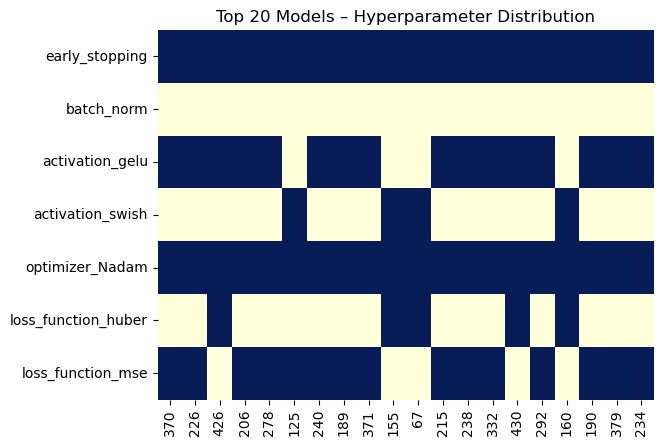

In [61]:
top_models = df.sort_values("composite_score").head(20)
top_cats = top_models[["activation", "optimizer", "loss_function", "early_stopping", "batch_norm"]]

sns.heatmap(pd.get_dummies(top_cats).T, cmap="YlGnBu", cbar=False)
plt.title("Top 20 Models – Hyperparameter Distribution")
plt.show()


In [62]:
best_model = df.sort_values("composite_score").iloc[0]
top_5_avg = df.sort_values("composite_score").head(5)[[
    "mae", "rmse", "r2", "mape", "median_ae", "dropout_rate", "learning_rate", "depth", "num_units"
]].mean()

summary = pd.DataFrame({
    "Best Model": best_model[["mae", "rmse", "r2", "mape", "median_ae", "dropout_rate", "learning_rate"]],
    "Top 5 Avg": top_5_avg
})

import pandas as pd
summary.index.name = "Metric"
summary.reset_index(inplace=True)
summary


KeyError: "['depth', 'num_units'] not in index"

In [ ]:
import seaborn as sns

residuals = y_true.flatten() - y_pred.flatten()

plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=50, kde=True, color="steelblue")
plt.axvline(0, color='black', linestyle='--', lw=1)
plt.title("Residual Error Distribution – Best Model")
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("IMAGES/error_histogram.png")
plt.show()


NameError: name 'y_true' is not defined

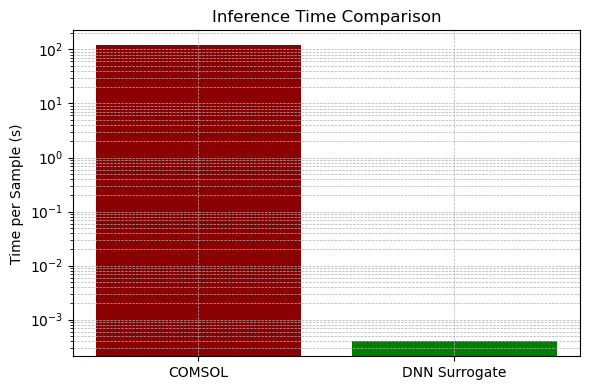

In [ ]:
import matplotlib.pyplot as plt

# Placeholder values — update with real COMSOL time if known
comsol_time_sec = 120.0  # e.g., 2 minutes
dnn_time_ms = best_model["inference_time_ms"]
dnn_time_sec = dnn_time_ms / 1000

plt.figure(figsize=(6, 4))
bars = plt.bar(["COMSOL", "DNN Surrogate"], [comsol_time_sec, dnn_time_sec], color=["darkred", "green"])
plt.ylabel("Time per Sample (s)")
plt.title("Inference Time Comparison")
plt.yscale("log")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig("IMAGES/inference_speed_comparison.png")
plt.show()
